---
#Copy of L177 - Examine Feature Maps

(code below is from `DUDL_CNN_GaussClassFeatureMaps.ipynb`)


In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from dataclasses import dataclass
from datetime import datetime

from torchvision import datasets
from torchvision.transforms import v2
from PIL import Image
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder



In [25]:
# Define the transformation
pix_per_side = 64  # image size
batch_size = 4  # batch size

transform = transforms.Compose([
    transforms.Resize((pix_per_side, pix_per_side)),                 # Resize image
    transforms.ToTensor(),                                           # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load images from a directory
dataset = ImageFolder('C:/MyPythonCoding/MyDeepLearningCoding/images_512x512', transform=transform)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
    
# Create a DataLoader (no labels required)
data_loader = torch.utils.data.DataLoader(MyDataset(dataset), batch_size=batch_size,drop_last=True, shuffle=True)

print('\nDataloader Details:...\n')
print('Number of samples: ', len(data_loader.dataset))
print('Batch size: ', batch_size)
print('Number of batches: ', len(data_loader))

first_item = next(iter(data_loader))[0]     # Get first item in the first batch
print('\nshape of first item in first batch: ',first_item.shape)

print('dataloader created')


Dataloader Details:...

Number of samples:  159
Batch size:  4
Number of batches:  39

shape of first item in first batch:  torch.Size([4, 3, 64, 64])
dataloader created


In [26]:
def unnormalize(img):
    '''un-normalises, un-scales, and converts the image from Tensor to Numpy for display'''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

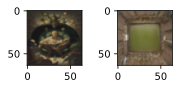

In [27]:
# sanity check - display a couple of images
# Get the first batch of data and labels
data, labels = next(iter(data_loader))

# Now you can access the data
tmp1 = unnormalize(data[0])
tmp2 = unnormalize(data[1])

fig,ax = plt.subplots(1,2,figsize=(3,1))
ax[0].imshow(tmp1)
ax[1].imshow(tmp2)
plt.show()

In [28]:
#global variables
chanConv1 = 6 # number of output channels for first convolutional layer
chanConv2 = 6 # number of output channels for second convolutional layer

In [42]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,chanConv1,3,padding=1, stride=1)
      
      self.conv2 = nn.Conv2d(chanConv1,chanConv2,3,padding=1, stride=1)
      
      # fc1
      self.fc1 = nn.Linear(chanConv2*16*16,100) # FLATTEN input features from final conv layer eg: FM channels x W x H x 3(RGB)

      # fc2 (output)
      self.fc2 = nn.Linear(100,10)

      # dropout function with [0-1] probability of dropout
      self.dropout = nn.Dropout(0.4)

    def forward(self,x):
      # first conv-pool set
      x = self.conv1(x)
      conv1act = F.leaky_relu(x) # grab variable so we can return this as well as net results
      x = self.dropout(conv1act)  # Apply dropout after ReLU activation
      x = F.avg_pool2d(x,(2,2))

      # second conv-pool set
      x = self.conv2(x)
      conv2act = F.leaky_relu(x) # grab variable so we can return this as well as net results
      x = self.dropout(conv2act)  # Apply dropout after ReLU activation
      x = F.max_pool2d(x,(2,2))

      # FCN part
      x = x.reshape(x.shape[0],-1) # flatten
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)
      return x,conv1act,conv2act #returns results AND Feature Maps

  # create the model instance
  net = gausnet()

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [43]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(data_loader))
X = X.float()  # Convert X to float
yHat,featmap1,featmap2 = net(X) # get the feature maps as well as yHat predictions
# if this line fails, you likely have a size mismatch : RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x144 and 1024x100). alter the 144 to match the number of features from the final conv layer
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([4, 10])

Feature map after conv1
torch.Size([4, 6, 64, 64])

Feature map after conv2
torch.Size([4, 6, 32, 32])


In [44]:
# count the total number of parameters in the model - pass a single input image through the model       
summary(net)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            168
├─Conv2d: 1-2                            330
├─Linear: 1-3                            153,700
├─Linear: 1-4                            1,010
├─Dropout: 1-5                           --
Total params: 155,208
Trainable params: 155,208
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            168
├─Conv2d: 1-2                            330
├─Linear: 1-3                            153,700
├─Linear: 1-4                            1,010
├─Dropout: 1-5                           --
Total params: 155,208
Trainable params: 155,208
Non-trainable params: 0

torch.Size([6, 3, 3, 3])

k1: max= tensor(0.1913)   min= tensor(-0.0828) 
 tensor([[ 0.1306,  0.0099, -0.0828],
        [-0.0807,  0.1913,  0.0421],
        [-0.0812,  0.0907,  0.1114]])

k2: max= tensor(0.1523)   min= tensor(-0.1206) 
 tensor([[ 0.0705, -0.0816,  0.1523],
        [ 0.0638, -0.0560,  0.0620],
        [-0.1206,  0.1082, -0.0888]])


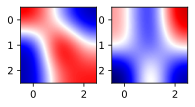

In [51]:
# view first convolution layer kernels. note these will be random noise since the model has not been trained
# re-run this cell after training to see the learned kernels

layer = list(net.modules())[1] # get the first layer (conv1)
kernel = layer.weight.data
print(kernel.shape)
k1=kernel[0,0,:,:]
k2=kernel[1,0,:,:]
rangemax = max(k1.max(),k2.max())
rangemin = min(k1.min(),k2.min())

print('\nk1: max=',k1.max(),'  min=',k1.min(),'\n',k1)
print('\nk2: max=',k2.max(),'  min=',k2.min(),'\n',k2)

# plot the 2 kernels
fig, ax = plt.subplots(1, 2, figsize=(3, 2))
ax[0].imshow(kernel[0,0,:,:],cmap='seismic',vmin=rangemin,vmax=rangemax,interpolation='bicubic')
ax[1].imshow(kernel[1,0,:,:],cmap='seismic',vmin=rangemin,vmax=rangemax,interpolation='bicubic')
plt.show()

In [56]:
def function2trainTheModel():
  numepochs = 2

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in data_loader:

      # forward pass and loss
      X = X.float()  # Convert X to float
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( (torch.argmax(yHat, dim=1) == y).float().mean().item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # # calc TEST accuracy
    # X,y = next(iter(test_loader)) # extract X,y from test dataloader
    # with torch.no_grad():         # deactivate autograd
    #   X = X.float()               # Convert X to float
    #   yHat = net(X)[0]            # we only need the first output, no labels
    #   loss = lossfun(yHat,y)

    # testLoss[epochi] = loss.item()
    # testAcc[epochi]  = 100*torch.mean((torch.argmax(yHat, dim=1) == y).float()).item()
    # print ('epoch:',epochi, ' Test Accuracy:',round(testAcc[epochi].item(),2),'%')
    print ('epoch:',epochi)
    
  return trainLoss,testLoss,trainAcc,testAcc,net

TRAIN model, show results

In [57]:
trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel()


epoch: 0
epoch: 1


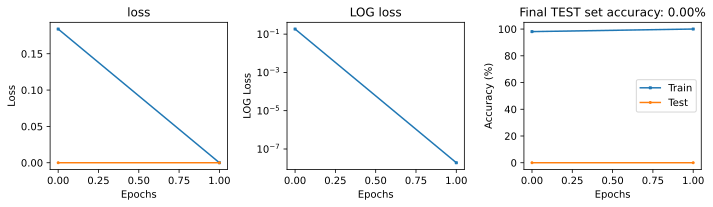

In [58]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

ax[0].plot(trainLoss,'s-',label='Train',markersize=2)
ax[0].plot(testLoss,'o-',label='Test',markersize=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('loss')

ax[1].plot(trainLoss,'s-',label='Train',markersize=2)
ax[1].plot(testLoss,'o-',label='Test',markersize=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('LOG Loss')
ax[1].set_title('LOG loss')
ax[1].set_yscale('log')

ax[2].plot(trainAcc,'s-',label='Train',markersize=2)
ax[2].plot(testAcc,'o-',label='Test',markersize=2)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title(f'Final TEST set accuracy: {testAcc[-1]:.2f}%')
ax[2].legend()
plt.tight_layout()
plt.show()

IndexError: index 4 is out of bounds for dimension 0 with size 4

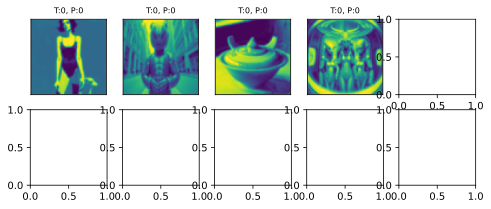

In [61]:
# visualize some images
X,y = next(iter(data_loader)) # extract X,y from dataloader
yHat,featmap1,featmap2 = net(X.float())

fig,axs = plt.subplots(2,5,figsize=(8,3))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G)
  t = ( int(y[i].item()) , torch.argmax(yHat[i]).item() )
  #set small font size
  ax.set_title('T:%s, P:%s'%t,fontsize=8)
  
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Draw the feature maps

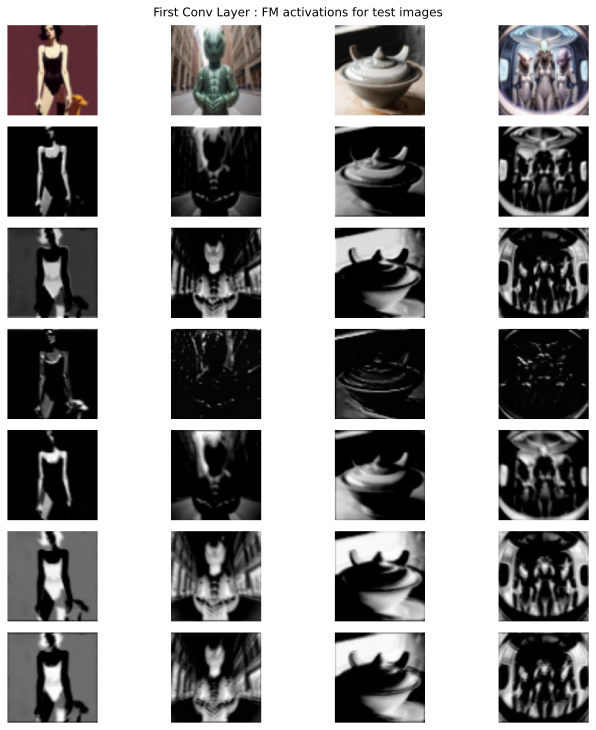

In [73]:
# Feature maps from the conv1 layer
fig,axs = plt.subplots(chanConv1+1,4,figsize=(10,10))
for pici in range(4): # keep this under the number of images in the batch
  img = X[pici,:,:,:].detach()                      # the original picture
  img = unnormalize(img)                         
  axs[0,pici].imshow(img)
  axs[0,pici].axis('off')

  for feati in range(chanConv1):
    # extract feature maps for this image
    img = featmap1[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='gray',interpolation='bilinear')
    axs[feati+1,pici].axis('off')

plt.tight_layout()
plt.suptitle('First Conv Layer : FM activations for test images',x=.5,y=1.01)
plt.show()

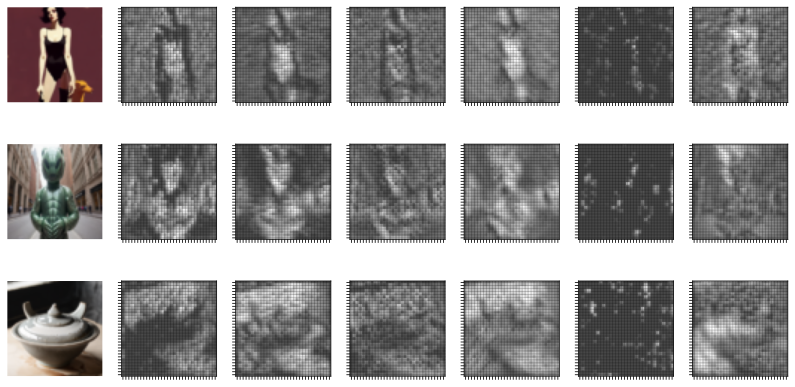

In [67]:
# Repeat for feature2 maps
fig,axs = plt.subplots(3,chanConv2+1,figsize=(14,7))
for pici in range(3):
  #need to change - this is taking greyscale - need to run thru un-normalise function
  img = X[pici,:,:,:].detach() # show original picture
  img = unnormalize(img)
  axs[pici,0].imshow(img)
  axs[pici,0].axis('off')
  for feati in range(chanConv2):

    # extract the feature map from this image
    img = featmap2[pici,feati,:,:].detach()
    axs[pici,feati+1].imshow(img,cmap='gray',vmin=0,vmax=torch.max(img)*.9,interpolation='bicubic',alpha=.8)
    axs[pici,feati+1].imshow(img,cmap='gray',vmin=0,vmax=torch.max(img)*.9,interpolation='nearest',alpha=.5)
    
    # set x and y ticks
    axs[pici,feati+1].set_xticks(np.arange(0, img.shape[1], 1))  # replace final no. with desired x-spacing
    axs[pici,feati+1].set_yticks(np.arange(0, img.shape[0], 1))  # replace with desired y-spacing
    
    # remove x and y tick labels
    axs[pici,feati+1].set_xticklabels([])
    axs[pici,feati+1].set_yticklabels([])
    
    # plot grid
    axs[pici,feati+1].grid(True, which='both', color='k', linewidth=1, linestyle='-', alpha=.2)

plt.show()

# Spatial correlations across the feature maps

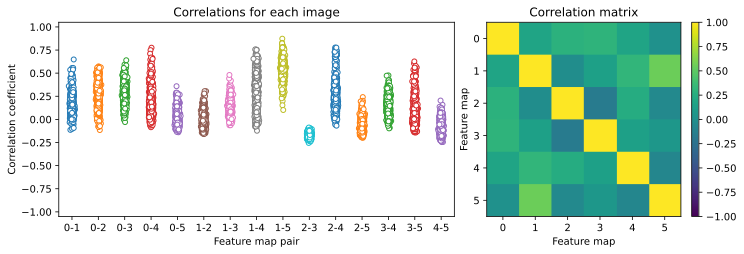

In [ ]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))


# now visualize the correlations
fig = plt.figure(figsize=(10,3))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=5)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

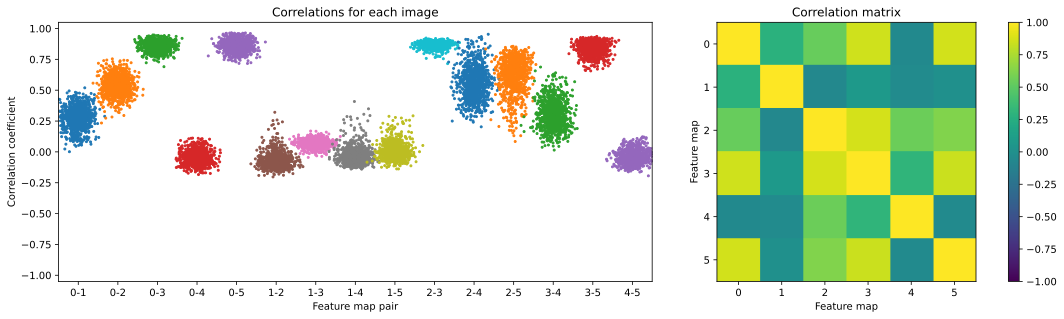

In [ ]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]

# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))

# visualize FM-pair correlations
fig = plt.figure(figsize=(15,4))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/5,allrs[:,i],'o',markersize=2)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
fig.colorbar(h,cax=cax)
plt.show()

Additional explorations

* The code grabs the Feature Maps *after* relu. Modify to get *pre-relu* activations, which corresponds to the linear part of the activations. (may need to modify color range?). Are they different before vs after relu? Which maps are more relevant to interpret when trying to understand how the CNN works and how it represents data?

* Relatedly, look at activations after pooling layers? Which is better and what are the advantages of inspecting the pre- vs. post-pooled activation maps?
